# Set-TSP - Because There Is More Than One Place to Get Bread

## This notebook was created to serve a blog post by the same name.

In [1]:
# written in python 3.7.3
import json
import random

import geojsonio
import numpy as np
import pandas as pd
from geojson import LineString, Point, Feature, FeatureCollection
from math import cos, asin, sqrt, degrees, atan2

import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 42
random.seed(random_seed)

# Part I - The Geographic Building Blocks

### For more information on Haversine formula, go to [this](https://en.wikipedia.org/wiki/Haversine_formula) wiki page, 

### and for the specific formulation used here go to [this](https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula/21623206#21623206) Stackoverflow answer

In [2]:
p = 0.017453292519943295  # Pi / 180
r = 12742000  # Earth's radius is ~6371km => r = 2 * Earth's radius

class GeoPoint:
    def __init__(self, lng: float, lat: float, name_: str = None):
        # Why 5 digits? According to https://en.wikipedia.org/wiki/Decimal_degrees it's 1m. accuracy.
        self.lng = round(lng, 5)
        self.lat = round(lat, 5)
        self.name_ = name_
        
    def __repr__(self):
        # Copy-pastable format for most map applications
        name_str = f"{self.name_}, " if self.name_ is not None else ""
        return f"[{name_str}{self.lat}, {self.lng}]"
    
    def get_dist_from(self, other) -> int:
        # Return non-euclidean distance in meters, using Haversine formula
        # For more information on this formulation go to 
        a = (0.5 
             - cos((other.lat - self.lat) * p)/2 
             + (cos(self.lat * p) 
                * cos(other.lat * p) 
                * (1 - cos((other.lng - self.lng) * p)) / 2))
        d = int(r * asin(sqrt(a))) 
        return d

In [3]:
def get_all_geopoints_from_all_sets(all_sets):
    geo_points = [g
                  for set_ in all_sets
                  for g in set_]
    return geo_points

In [4]:
def get_distances_array_and_set_to_points_dict(all_sets):
    all_geo_points = []
    set_to_points_dict = {}
    first_point_idx = 0
    for idx, set_ in enumerate(all_sets):
        all_geo_points += set_
        n_points_in_set = len(set_)
        set_to_points_dict[idx] = list(range(first_point_idx, first_point_idx + n_points_in_set))
        first_point_idx += n_points_in_set

    n_points = first_point_idx
    distances_array = np.array([[all_geo_points[i].get_dist_from(all_geo_points[j])
                                 for i in range(n_points)]
                                for j in range(n_points)])

    return all_geo_points, set_to_points_dict, distances_array

In [5]:
bread_0 = GeoPoint(lat=32.178500, lng=34.906531, name_="bread_0")
bread_1 = GeoPoint(lat=32.175431, lng=34.907089, name_="bread_1")
bread_2 = GeoPoint(lat=32.175041, lng=34.898474, name_="bread_2")
bread_set = [bread_0, bread_1, bread_2]

veg_0 = GeoPoint(lat=32.178192, lng=34.899633, name_="veg_0")
veg_1 = GeoPoint(lat=32.176376, lng=34.902369, name_="veg_1")
veg_2 = GeoPoint(lat=32.174051, lng=34.899397, name_="veg_2")
veg_set = [veg_0, veg_1, veg_2]

beer_0 = GeoPoint(lat=32.177774, lng=34.907175, name_="beer_0")
beer_1 = GeoPoint(lat=32.177102, lng=34.899719, name_="beer_1")
beer_set = [beer_0, beer_1]

all_sets = [bread_set, veg_set, beer_set]

In [6]:
all_geo_points, set_to_points_dict, distances_array = get_distances_array_and_set_to_points_dict(all_sets)

print(all_geo_points)
print(set_to_points_dict)
distances_array

[[bread_0, 32.1785, 34.90653], [bread_1, 32.17543, 34.90709], [bread_2, 32.17504, 34.89847], [veg_0, 32.17819, 34.89963], [veg_1, 32.17638, 34.90237], [veg_2, 32.17405, 34.8994], [beer_0, 32.17777, 34.90718], [beer_1, 32.1771, 34.89972]]
{0: [0, 1, 2], 1: [3, 4, 5], 2: [6, 7]}


array([[  0, 345, 850, 650, 457, 833, 101, 659],
       [345,   0, 812, 766, 456, 739, 260, 718],
       [850, 812,   0, 366, 396, 140, 874, 257],
       [650, 766, 366,   0, 327, 460, 712, 121],
       [457, 456, 396, 327,   0, 381, 478, 261],
       [833, 739, 140, 460, 381,   0, 840, 340],
       [101, 260, 874, 712, 478, 840,   0, 706],
       [659, 718, 257, 121, 261, 340, 706,   0]])

# Part II - Solving Using Dynammic Programming

In [7]:
def DP_Set_TSP(set_to_points_dict, distances_array):
    all_sets = set(set_to_points_dict.keys())
    n_sets = len(all_sets)

    # memo keys: tuple(sorted_sets_in_path, last_set_in_path, last_point_in_path)
    # memo values: tuple(cost_thus_far, next_to_last_set_in_path, next_to_last_point_in_path)
    memo = {(tuple([set_idx]), set_idx, p_idx): tuple([0, None, None])
            for set_idx, points_idxs in set_to_points_dict.items()
            for p_idx in points_idxs}
    queue = [(tuple([set_idx]), set_idx, p_idx)
             for set_idx, points_idxs in set_to_points_dict.items()
             for p_idx in points_idxs]

    while queue:
        prev_visited_sets, prev_last_set, prev_last_point = queue.pop(0)
        prev_dist, _, _ = memo[(prev_visited_sets, prev_last_set, prev_last_point)]

        to_visit = all_sets.difference(set(prev_visited_sets))
        for new_last_set in to_visit:
            new_visited_sets = tuple(sorted(list(prev_visited_sets) + [new_last_set]))
            for new_last_point in set_to_points_dict[new_last_set]:
                new_dist = prev_dist + distances_array[prev_last_point][new_last_point]

                new_key = (new_visited_sets, new_last_set, new_last_point)
                new_value = (new_dist, prev_last_set, prev_last_point)

                if new_key not in memo:
                    memo[new_key] = new_value
                    queue += [new_key]
                else:
                    if new_dist < memo[new_key][0]:
                        memo[new_key] = new_value

    optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost = retrace_optimal_path(memo, n_sets)

    return optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost

In [8]:
def retrace_optimal_path(memo: dict, n_sets: int) -> [[int], [int], float]:
    sets_to_retrace = tuple(range(n_sets))

    full_path_memo = dict((k, v) for k, v in memo.items() if k[0] == sets_to_retrace)
    path_key = min(full_path_memo.keys(), key=lambda x: full_path_memo[x][0])

    _, last_set, last_point = path_key
    optimal_cost, next_to_last_set, next_to_last_point = memo[path_key]

    optimal_path_in_points_idxs = [last_point]
    optimal_path_in_sets_idxs = [last_set]
    sets_to_retrace = tuple(sorted(set(sets_to_retrace).difference({last_set})))

    while next_to_last_set is not None:
        last_point = next_to_last_point
        last_set = next_to_last_set
        path_key = (sets_to_retrace, last_set, last_point)
        _, next_to_last_set, next_to_last_point = memo[path_key]

        optimal_path_in_points_idxs = [last_point] + optimal_path_in_points_idxs
        optimal_path_in_sets_idxs = [last_set] + optimal_path_in_sets_idxs
        sets_to_retrace = tuple(sorted(set(sets_to_retrace).difference({last_set})))

    return optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost

In [9]:
def get_features_for_all_points(all_sets):
    points = []
    for set_ in all_sets:
        color = "#" + ''.join(random.choices('0123456789abcdef', k=6))
        points += [
            Feature(geometry=Point(tuple([g.lng, g.lat])),
                    properties={"name": g.name_,
                                "marker-symbol": int(g.name_[-1]),
                                "marker-color": color})
            for g in set_]
    return points

In [10]:
def plot_route_on_map(all_sets, optimal_path_in_points_idxs):
    points = get_features_for_all_points(all_sets)
    
    all_geo_points = get_all_geopoints_from_all_sets(all_sets)
    lng_lat_list = [tuple([all_geo_points[i].lng, all_geo_points[i].lat])
                    for i in optimal_path_in_points_idxs]
    route = Feature(geometry=LineString(lng_lat_list),
                    properties={"name": "This is our route",
                                "stroke": "black"})
    
    feature_collection = FeatureCollection(features=points+[route])
    geojsonio.display(json.dumps(feature_collection));

In [11]:
optimal_path_in_points, optimal_path_in_sets, optimal_cost = DP_Set_TSP(set_to_points_dict, distances_array)
print(optimal_path_in_points, optimal_path_in_sets, optimal_cost)

[2, 7, 3] [0, 2, 1] 378


In [12]:
# Opens a new tab in the browser :)
plot_route_on_map(all_sets, optimal_path_in_points)

# Part III - Larger Random Experiments

In [13]:
def get_random_geo_point(center_lat=32.1, center_lng=34.8, radius=0.1, name_=None):
    geo_point =  GeoPoint(lat = center_lat + (radius * random.random()), 
                          lng = center_lng + (radius * random.random()),
                          name_ = name_)
    return geo_point

In [14]:
def generate_random_input_in_geo_points(n_sets: int, poisson_lambda: int = 2) -> [{int: int}, {int: int}, np.array]:
    set_to_points_dict = {}
    first_point_idx = 0
    for set_idx in range(n_sets):
        n_points_in_set = 1 + np.random.poisson(poisson_lambda)
        set_to_points_dict[set_idx] = list(range(first_point_idx, first_point_idx + n_points_in_set))
        first_point_idx += n_points_in_set

    n_points = first_point_idx
    all_sets = []
    for idx_set in range(n_sets):
        all_sets += [[get_random_geo_point(name_=f's{idx_set}_i{idx_point}') 
                      for idx_point in range(len(set_to_points_dict[idx_set]))]]
    
    all_geo_points = get_all_geopoints_from_all_sets(all_sets)
    distances_array = np.array([[all_geo_points[i].get_dist_from(all_geo_points[j])
                                 for i in range(n_points)]
                                for j in range(n_points)])

    return all_sets, all_geo_points, set_to_points_dict, distances_array

In [15]:
n_sets = 10
poisson_lambda = 4
all_sets, all_geo_points, set_to_points_dict, distances_array = generate_random_input_in_geo_points(n_sets, poisson_lambda)
optimal_path_in_points, optimal_path_in_sets, optimal_cost = DP_Set_TSP(set_to_points_dict, distances_array)
print(optimal_path_in_points, optimal_path_in_sets, optimal_cost)

# Opens a new tab in the browser :)
plot_route_on_map(all_sets, optimal_path_in_points)

[18, 42, 28, 37, 52, 9, 1, 6, 23, 48] [3, 7, 5, 6, 9, 2, 0, 1, 4, 8] 8568


# Extra - Working with non-geo random input

In [16]:
def generate_random_input(n_sets: int, poisson_lambda: int = 2) -> [{int: int}, {int: int}, np.array]:
    set_to_points_dict = {}
    first_point_idx = 0
    for set_idx in range(n_sets):
        n_points_in_set = 1 + np.random.poisson(poisson_lambda)
        set_to_points_dict[set_idx] = list(range(first_point_idx, first_point_idx + n_points_in_set))
        first_point_idx += n_points_in_set

    n_points = first_point_idx
    X = np.random.rand(n_points, 3)
    distances_array = np.array([[np.linalg.norm(X[i] - X[j])
                                 for i in range(n_points)]
                                for j in range(n_points)])

    return X, set_to_points_dict, distances_array

In [17]:
def scatter_plot(X: np.array, clusters_in_idxs: [[int]]):
    x, y = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                      for one_cluster_in_idxs in clusters_in_idxs
                      for c_idx in one_cluster_in_idxs]))
    c = [color_idx
         for color_idx, one_cluster_in_idxs in enumerate(clusters_in_idxs)
         for _ in one_cluster_in_idxs]
    df = pd.DataFrame({'x': x, 'y': y, 'c': c})

    for color_idx, cluster_in_idxs in enumerate(clusters_in_idxs):
        df_temp = df[df['c'].isin([color_idx])]
        plt.plot(df_temp['x'].tolist(), df_temp['y'].tolist(), 'o', label=color_idx, markersize=8);

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [18]:
def plot_route(X, optimal_path_in_points_idxs, set_to_points_dict):
    scatter_plot(X, list(set_to_points_dict.values()))
    for p1, p2 in zip(optimal_path_in_points_idxs[:-1], optimal_path_in_points_idxs[1:]):
        plt.plot([X[p1, 0], X[p2, 0]], [X[p1, 1], X[p2, 1]], color='grey');

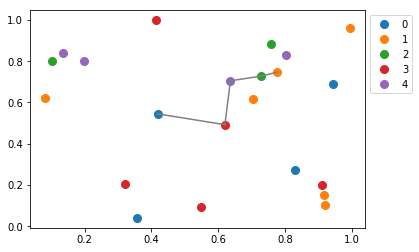

In [19]:
n_sets = 5
poisson_lambda = 3
X, set_to_points_dict, distances_array = generate_random_input(n_sets, poisson_lambda)

optimal_path_in_points_idxs, optimal_path_in_sets_idxs, optimal_cost = DP_Set_TSP(set_to_points_dict, distances_array)
plot_route(X, optimal_path_in_points_idxs, set_to_points_dict)